In [1]:
#Configuro el Google Colab conectandome a los datos desde la cuenta de Google
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [31]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from numpy.linalg import norm, svd, det, cond
import plotly.graph_objs as go
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Preparación de los datos

In [3]:
#1. Carga del Dataset
df = pd.read_csv('/content/gdrive/MyDrive/EAFIT/ProyectoIntegrador1/DatasetsRM/csv/all_files_E.csv')

In [4]:
# Eliminando columna redundante y convirtiendo la fecha
df = df.drop(columns=['Unnamed: 0'])
df['fecha'] = pd.to_datetime(df['fecha'])

In [5]:
# Limpieza y manejo de valores faltantes
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column].fillna(df[column].mean(), inplace=True)
    elif df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)

In [6]:
# Función para detectar outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data[column] < lower_bound) | (data[column] > upper_bound))

In [7]:
# Detección de outliers
outliers_dict = {}
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    outliers = detect_outliers_iqr(df, column)
    outliers_dict[column] = df[outliers]

print (outliers_dict)

{'requested_test_kv': Empty DataFrame
Columns: [serial, mfr, fecha, requested_test_kv, test_kv, ma, watts, measured_cap, pfm, pfm_tipup, line_id, group_number, circuit, location, division, company, cct_designation, stator_kv]
Index: [], 'test_kv': Empty DataFrame
Columns: [serial, mfr, fecha, requested_test_kv, test_kv, ma, watts, measured_cap, pfm, pfm_tipup, line_id, group_number, circuit, location, division, company, cct_designation, stator_kv]
Index: [], 'ma':        serial      mfr               fecha  requested_test_kv   test_kv  \
0      715015  Toshiba 2018-11-27 16:07:37                2.0  1.994720   
1      715015  Toshiba 2018-11-27 16:07:37                4.0  4.015733   
2      715015  Toshiba 2018-11-27 16:07:37                6.0  5.990353   
3      715015  Toshiba 2018-11-27 16:07:37                8.0  8.009873   
4      715015  Toshiba 2018-11-27 16:07:37                2.0  2.000625   
...       ...      ...                 ...                ...       ...   
12796 

In [8]:
# Aplicando transformaciones a las columnas con outliers
#for column, count in outliers_dict.items():
#    if count > 0:
#        if (df[column] > 0).all():
#            df[column + "_log"] = np.log(df[column])
#        else:
#            df[column + "_sqrt"] = np.sqrt(df[column].abs())

# Eliminando las columnas originales con outliers
#columns_to_drop = [column for column, count in outliers_dict.items() if count > 0]
#df_transformed = df.drop(columns=columns_to_drop)

Análisis Descriptivo de Variables:
       requested_test_kv       test_kv            ma          watts  \
count       17354.000000  17354.000000  17354.000000   17354.000000   
mean            4.715852      4.712992    729.815717     136.663912   
std             2.424405      2.406028    873.372180    2119.506093   
min             0.100000      0.084000      0.000000    -439.750000   
25%             2.000000      2.001000     10.447331       0.784098   
50%             4.000000      4.002000    371.477760      74.114000   
75%             6.000000      6.006173   1381.813512     162.030995   
max            12.000000     12.000000  27063.400000  270494.700000   

        measured_cap           pfm     pfm_tipup       line_id  group_number  \
count   17354.000000  17354.000000  17354.000000  17354.000000  17354.000000   
mean   192923.817077      1.836669      0.213581     22.097561      2.520341   
std    225259.181536      4.284171      1.333901     11.141986      1.760829   
min  

<ipython-input-9-6e4e8aac757b>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


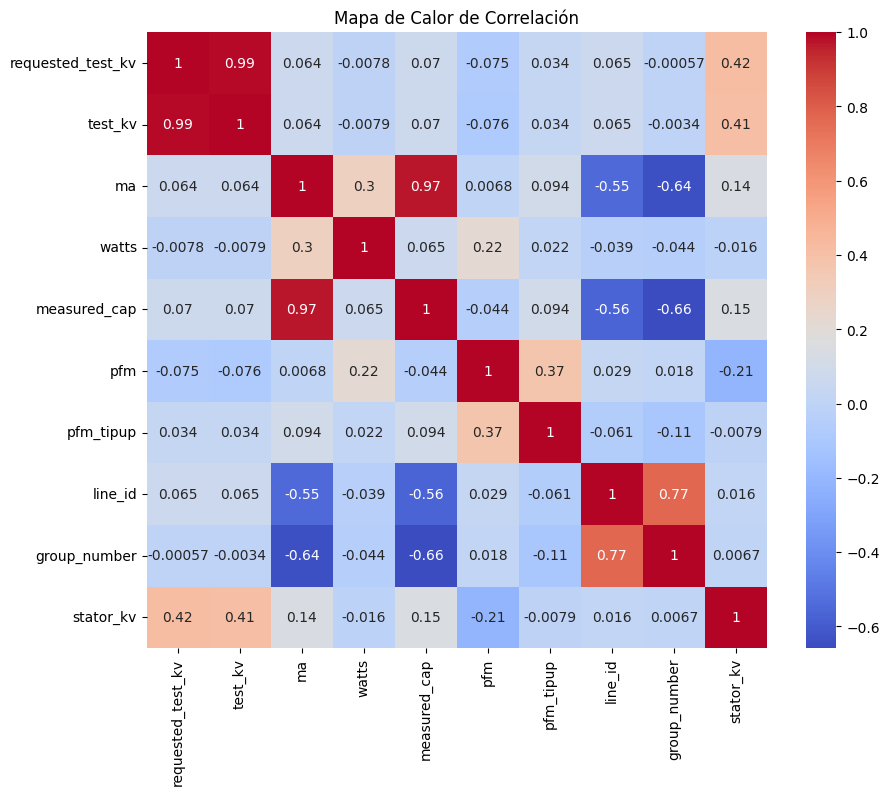

In [9]:
# Análisis descriptivo de las columnas transformadas
print("Análisis Descriptivo de Variables:")
print(df.describe())

# Correlación entre variables
print("\nMatriz de Correlación:")
correlation_matrix = df.corr()
print(correlation_matrix)

# Gráfico de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Mapa de Calor de Correlación")
plt.show()

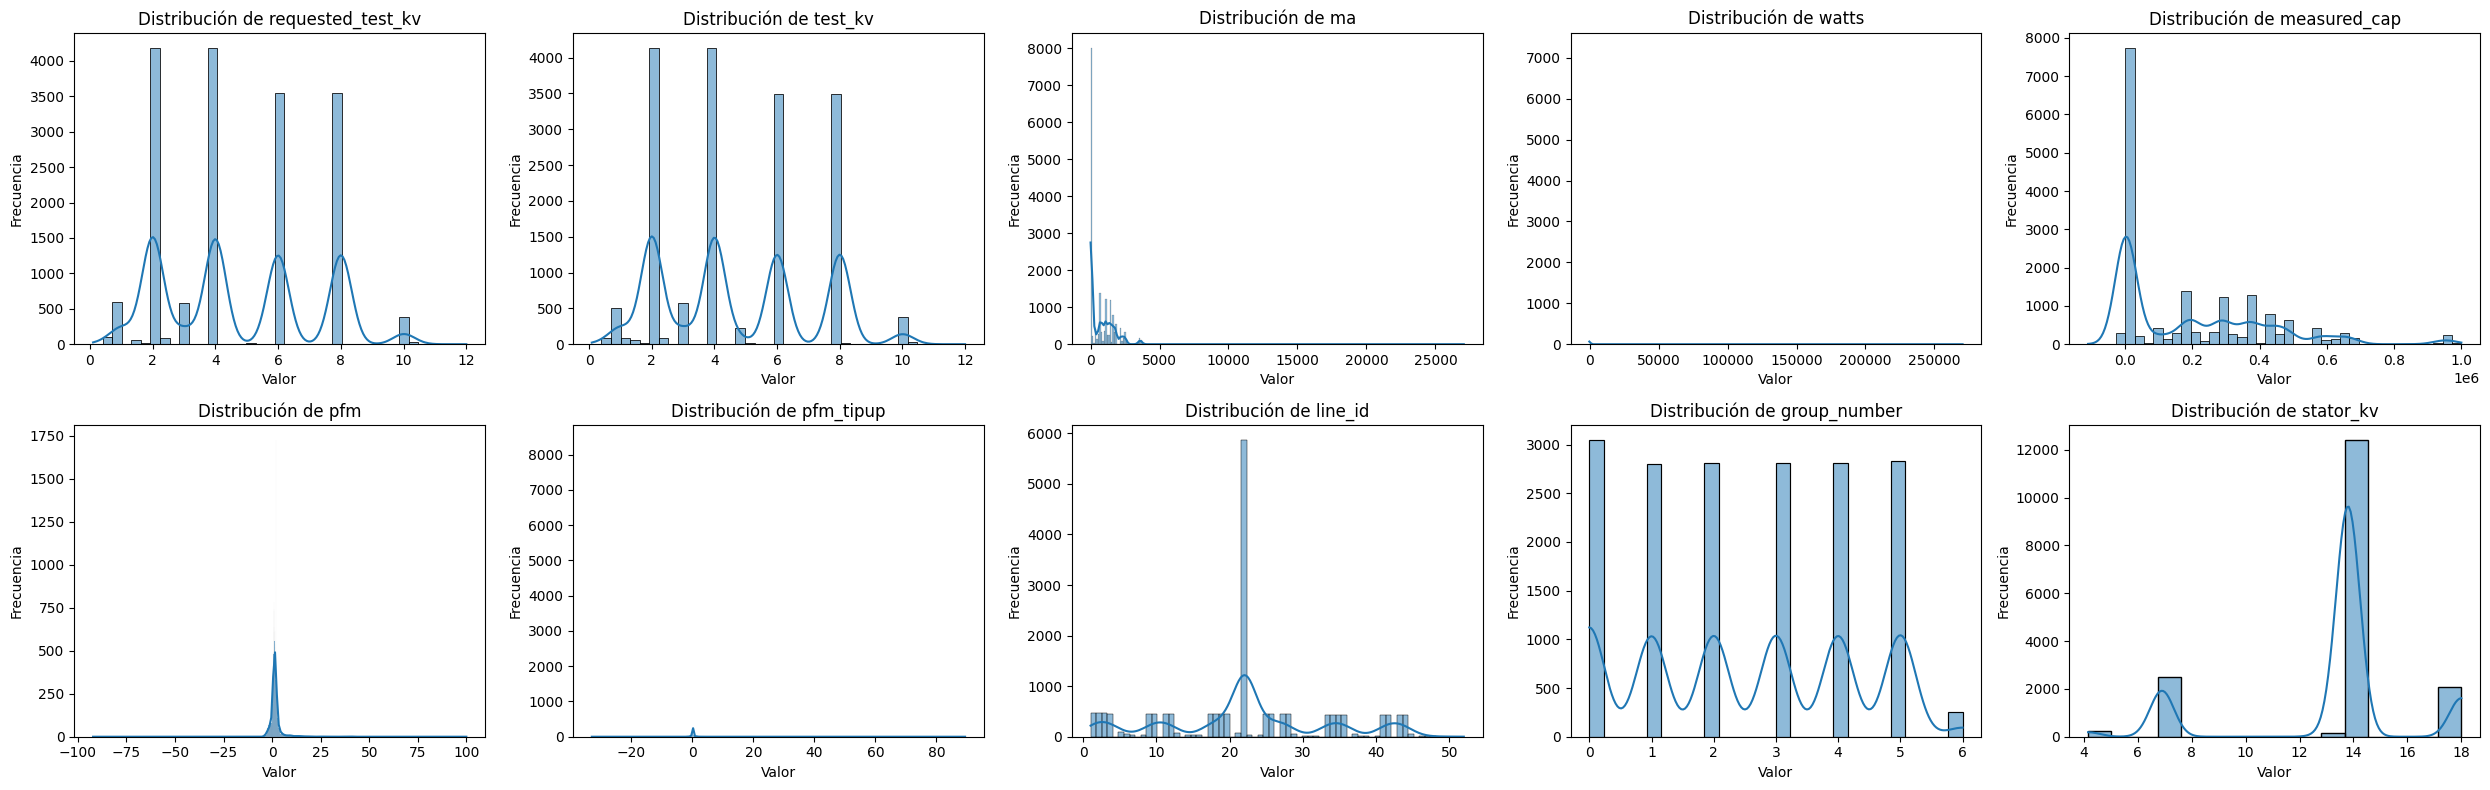

In [10]:
# Histogramas y gráficos de caja para las columnas transformadas
numeric_transformed_columns = df.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(numeric_transformed_columns)
num_rows = (num_plots // 5) + (1 if num_plots % 5 > 0 else 0)

plt.figure(figsize=(25, num_rows * 4))
for i, column in enumerate(numeric_transformed_columns, 1):
    plt.subplot(num_rows, 5, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

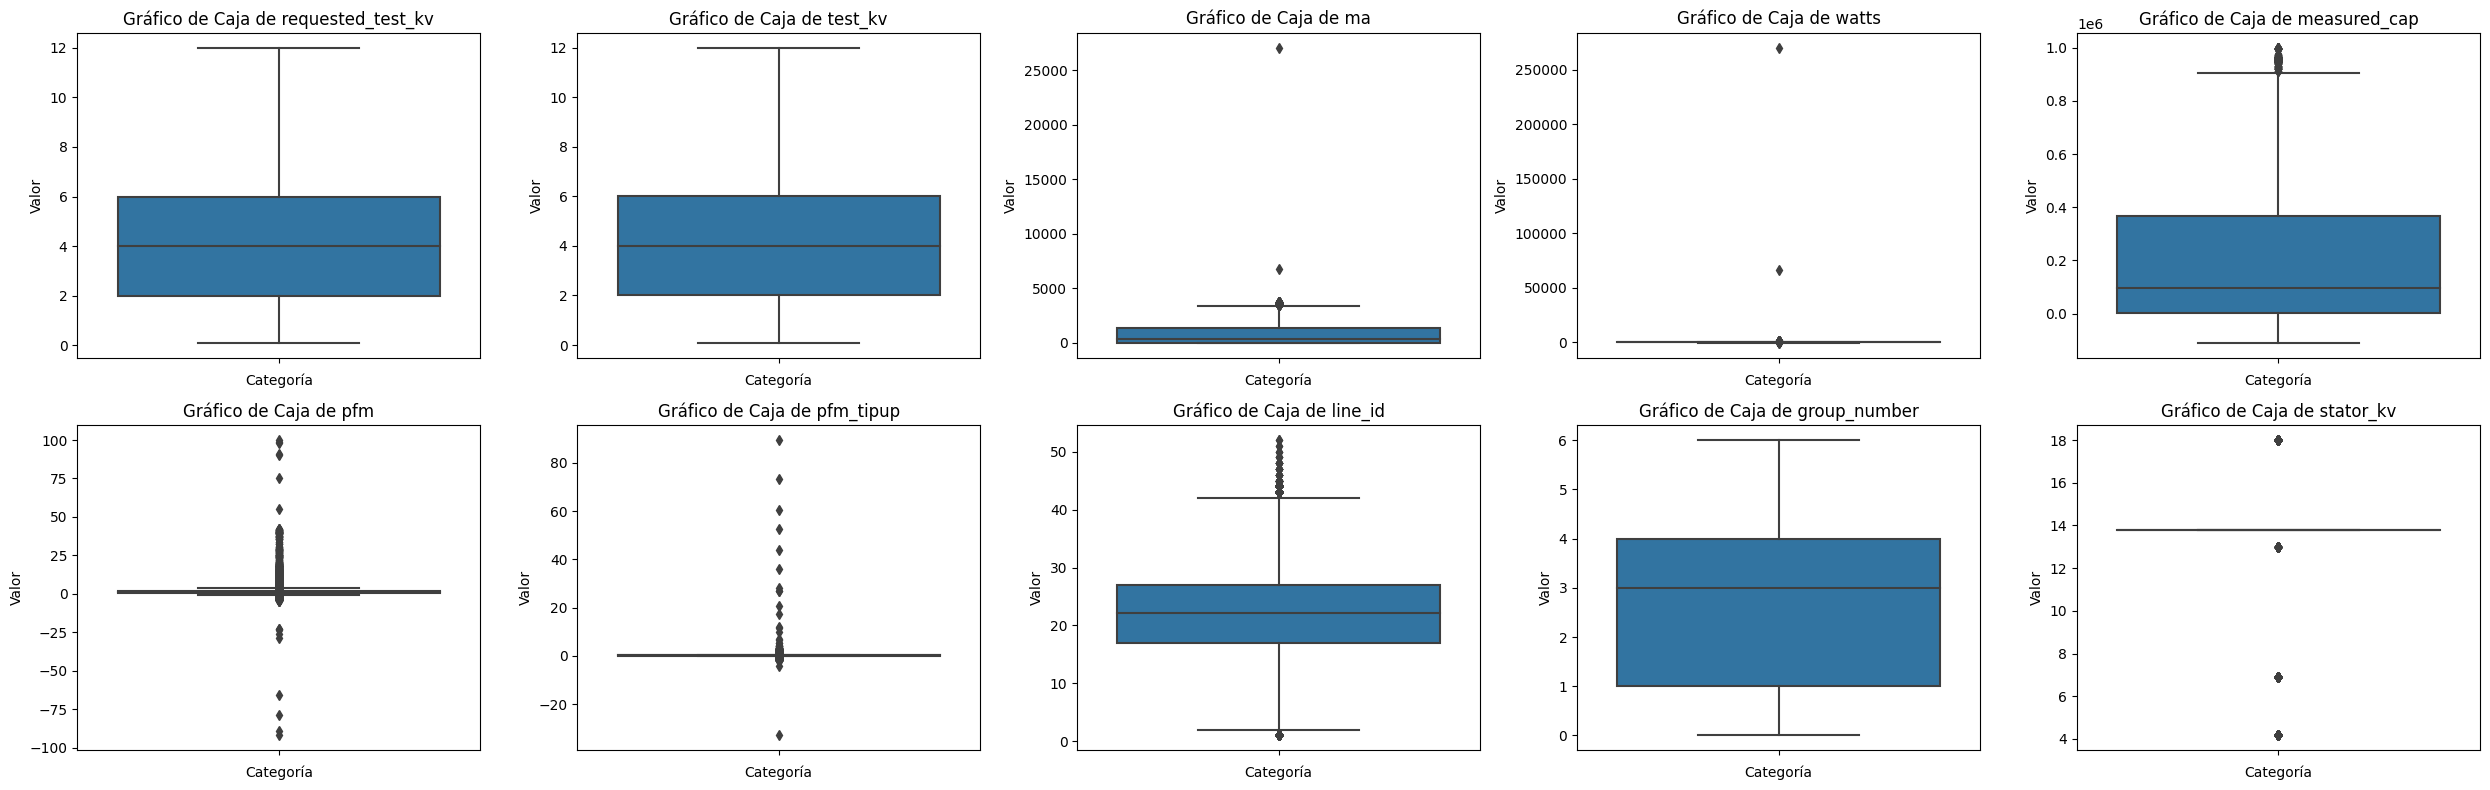

In [11]:
plt.figure(figsize=(25, num_rows * 4))
for i, column in enumerate(numeric_transformed_columns, 1):
    plt.subplot(num_rows, 5, i)
    sns.boxplot(y=df[column])
    plt.title(f'Gráfico de Caja de {column}')
    plt.xlabel('Categoría')
    plt.ylabel('Valor')

plt.tight_layout()
plt.show()

In [12]:
#Estandarizacion de columna mfr empleando diccionario

## Diccionario de mapeo de valores originales a valores deseados
mapeo = {
  'Ansal' : 'ANS',
  'General Electric' : 'GE',
  'Brown Boveri Company' : 'GMX',
  'Mitsubishi' : 'MIT',
  'ENERGOMEX' : 'ENG',
  'Rade-Koncar' : 'RK',
  'Toshiba' : 'TOS',
  'AEG Power Tool Corp.' : 'GMX',
  'Alstom' : 'ALS',
  'ASEA' : 'GMX',
  'RADE KONCAR' : 'RK',
  'Westinghouse Electric' : 'OTH',
  'TIBB' : 'GMX',
  'ABB (ASEA-Brown Boveri)' : 'GMX',
  'Koch & Sterzel' : 'OTH',
  'Hitachi' : 'HIT',
  'ASEA Inc.' : 'GMX',
  'Cenemesa' : 'OTH',
  'HITACHI' : 'HIT',
  'Raychem' : 'OTH',
  'Brush Ltd. (H-S Group)' : 'OTH',
  'HARBIN ELECTRIC MACHINERY' : 'OTH',
  'Magnetek' : 'OTH',
  'GAMESA' : 'OTH'
}

## Cambiar los valores en la columna 'mfr' utilizando el diccionario
df['mfr'] = df['mfr'].map(mapeo)

# Homologar valores de columna group_number
## Reemplazar los valores en la columna group_number
df['group_number'] = df['group_number'].replace({0: 'GST', 1: 'GST', 2: 'GST', 6:'GST', 3: 'UST', 4: 'UST', 5: 'UST'})

In [13]:
# Estandarizacion de valores para columna requested_text_kv (rtkv)

## Obtener los valores únicos de la columna 'requested_test_kv'
valores_rtkv = df['requested_test_kv'].unique()
#Reemplazo de valores
## Diccionario de reemplazo
diccionario_reemplazo = {
    2.5: 2.,
    2.3: 2.,
    2.4: 2.,
    3.8: 4.,
    10.4: 10.,
    10.0: 10.,
    5.9: 6.,
    6.1: 6.,
    8.1: 8.,
    8.2: 8.,
    1.9: 2.,
    7.9: 8.,
    2.1: 2.,
    9.9: 10.,
    10.3: 10.,
    10.2: 10.,
    10.4: 10.
}
df.loc[:, 'requested_test_kv'] = df['requested_test_kv'].replace(diccionario_reemplazo)

## Registros a depurar basados en la columna 'requested_test_kv' por ser no válidos para el análisis
valores_a_eliminar = [0.2, 0.5, 1.4, 1.5, 0.8, 0.1, 5.5, 7, 9 ]

## Eliminar filas con los valores especificados
df = df[~df['requested_test_kv'].isin(valores_a_eliminar)]

## Obtener los valores únicos de la columna 'requested_test_kv'
valores_rtkv = df['requested_test_kv'].unique()
valores_rtkv


array([ 2.,  4.,  6.,  8.,  1.,  3., 10.,  5., 12.])

In [14]:
# Eliminacion valores no válidos (0, NaN, NULL, etc)
## Contar la cantidad de NaN en df
#cantidad_nan = df.isna().sum()
#print(f"Cantidad de NaN en {'df'}: {cantidad_nan}")

columna_filtrar = 'ma'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]
columna_filtrar = 'measured_cap'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]
columna_filtrar = 'pfm'
df = df[(df[columna_filtrar] != 0) & (~df[columna_filtrar].isna())]

## Contar la cantidad de NaN en df
#cantidad_nan = df.isna().sum()
#print(f"Cantidad de NaN en {'df'}: {cantidad_nan}")
df.to_csv('datafiles_clean.csv')

# **Evaluación PCA**

In [15]:
##Aplicacion PCA
# Preprocesamiento: Estandarización de los datos (importante para PCA)
# Selecciona solo las columnas numéricas para PCA
numeric_df = df.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Aplicación de PCA
pca = PCA(n_components=2)  # Reducir a 2 dimensiones para visualización
pca.fit(scaled_data)

# Creando el gráfico de cargas con Plotly
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = go.Figure()

# Agregando las flechas de las cargas
for i, loading in enumerate(loadings):
    fig.add_trace(go.Scatter(x=[0, loading[0]], y=[0, loading[1]],
                             mode='lines+text',
                             text=[None, numeric_df.columns[i]],
                             textposition="top center",
                             line=dict(width=2, color='blue')))

# Configurando el layout del gráfico
fig.update_layout(title='Gráfico de Cargas en PCA',
                  xaxis_title='Componente Principal 1',
                  yaxis_title='Componente Principal 2',
                  showlegend=False,
                  width=800,
                  height=600)

fig.show()

In [16]:
# Valores y vectores propios (para la identificación de proyecciones y reducción de dimensiones)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Normas (para calcular varianzas globales)
eigen_norms = norm(eigenvectors, axis=1)

# Productos internos (para identificar asociaciones lineales entre variables)
inner_products = np.dot(scaled_data, eigenvectors.T)

# Calculando la matriz de covarianza de los datos escalados
cov_matrix = np.cov(scaled_data, rowvar=False)

# Calculando el determinante de la matriz de covarianza
determinant_cov_matrix = np.linalg.det(cov_matrix)

# Descomposición en valores singulares (SVD)
u, s, vt = svd(scaled_data)

# Número de condición de las matrices de covarianzas (para evaluar la estabilidad numérica)
cov_matrix = np.cov(scaled_data, rowvar=False)
condition_number = cond(cov_matrix)

In [17]:
# Imprimiendo los resultados
print("Valores Propios:", eigenvalues)
print("Vectores Propios:", eigenvectors)
print("Normas de los Vectores Propios:", eigen_norms)
print("Productos Internos:", inner_products)
print("Determinante de la Matriz de Covarianza:", determinant_cov_matrix)
print("Descomposición en Valores Singulares:", s)
print("Número de Condición de la Matriz de Covarianza:", condition_number)

Valores Propios: [3.27139251 2.24190306]
Vectores Propios: [[ 0.12475328  0.12475562  0.53017665  0.50001531  0.52987911  0.00302322
   0.10878496 -0.36285926  0.11613802]
 [ 0.62082874  0.61985164 -0.09169715 -0.07082495 -0.09147964 -0.13558846
  -0.04655351  0.17349592  0.39737924]]
Normas de los Vectores Propios: [1. 1.]
Productos Internos: [[ 4.81510482 -2.38907661]
 [ 5.22600209 -1.37274077]
 [ 5.58276695 -0.36382363]
 ...
 [-1.97038656  0.19982569]
 [-1.79482915  1.24771936]
 [-1.61915917  2.29580434]]
Determinante de la Matriz de Covarianza: 8.073649527594341e-07
Descomposición en Valores Singulares: [236.7185721  195.9631535  156.31003486 114.05849401 100.99894582
  96.80570111  50.8540716   11.29490402   2.17962456]
Número de Condición de la Matriz de Covarianza: 11795.090532419475


PCA proporciona una herramienta valiosa para sintetizar y analizar datos complejos. Nos permite una comprensión más profunda y facilita el análisis predictivos o de diagnóstico.

*   En este caso, el tratamiento de datos empleando PCA nos permite identificar las variables que mayor incidencia tienen en el set de datos; se puede identificar una alta colinealidad entre las variables 'ma', 'watts' y 'measured_cap', dadas las cercanías en sus coeficientes; El método tradicional emplea siempre evaluar 'pfm' vs 'requested_test_kv', y se observa que si bien los pesos son bajos, no hay una colinealidad.
*   Las componentes principales se construyen para ser ortogonales entre sí, lo que significa que no están correlacionadas. Sin embargo, cuando se interpreta la importancia relativa de las variables en una componente principal, la presencia de pesos similares para múltiples variables puede indicar la existencia de patrones o estructuras subyacentes en los datos.
*   La matriz de correlacion permite llegar a la misma conclusión.
*   De acuerdo con las prácticas de industria se decide contiuar con la evalaucion entre variables 'requested_test_kv' y 'pfm'.

# Ejercicios de Clusterización, creación de familias de datos

In [18]:
# Obtener el array de los valores sin repetidos
array_valores_no_repetidos = list(set(mapeo.values()))

# Imprimir el array de los valores
print(array_valores_no_repetidos)

['ANS', 'HIT', 'OTH', 'ENG', 'ALS', 'GE', 'RK', 'TOS', 'MIT', 'GMX']


In [19]:
# Definir los arrays
array_a = ['GST', 'UST']
array_b = [6.9, 13.8, 18]
array_c = array_valores_no_repetidos
array_d = [1,2,3,4,6,8,10]

# Obtener todas las combinaciones posibles
combinaciones = list(product(array_a, array_b, array_c,array_d))

 # Mostrar el tamaño de la lista
print("Tamaño de la lista de combinaciones:", len(combinaciones))
combinaciones
# Imprimir las combinaciones
#print(combinaciones)

Tamaño de la lista de combinaciones: 420


[('GST', 6.9, 'ANS', 1),
 ('GST', 6.9, 'ANS', 2),
 ('GST', 6.9, 'ANS', 3),
 ('GST', 6.9, 'ANS', 4),
 ('GST', 6.9, 'ANS', 6),
 ('GST', 6.9, 'ANS', 8),
 ('GST', 6.9, 'ANS', 10),
 ('GST', 6.9, 'HIT', 1),
 ('GST', 6.9, 'HIT', 2),
 ('GST', 6.9, 'HIT', 3),
 ('GST', 6.9, 'HIT', 4),
 ('GST', 6.9, 'HIT', 6),
 ('GST', 6.9, 'HIT', 8),
 ('GST', 6.9, 'HIT', 10),
 ('GST', 6.9, 'OTH', 1),
 ('GST', 6.9, 'OTH', 2),
 ('GST', 6.9, 'OTH', 3),
 ('GST', 6.9, 'OTH', 4),
 ('GST', 6.9, 'OTH', 6),
 ('GST', 6.9, 'OTH', 8),
 ('GST', 6.9, 'OTH', 10),
 ('GST', 6.9, 'ENG', 1),
 ('GST', 6.9, 'ENG', 2),
 ('GST', 6.9, 'ENG', 3),
 ('GST', 6.9, 'ENG', 4),
 ('GST', 6.9, 'ENG', 6),
 ('GST', 6.9, 'ENG', 8),
 ('GST', 6.9, 'ENG', 10),
 ('GST', 6.9, 'ALS', 1),
 ('GST', 6.9, 'ALS', 2),
 ('GST', 6.9, 'ALS', 3),
 ('GST', 6.9, 'ALS', 4),
 ('GST', 6.9, 'ALS', 6),
 ('GST', 6.9, 'ALS', 8),
 ('GST', 6.9, 'ALS', 10),
 ('GST', 6.9, 'GE', 1),
 ('GST', 6.9, 'GE', 2),
 ('GST', 6.9, 'GE', 3),
 ('GST', 6.9, 'GE', 4),
 ('GST', 6.9, 'GE', 6),


In [20]:
def obtener_datos_por_combinacion(_df, combinacion):
    # Filtrar el DataFrame según la combinación actual
    filtro = (_df['group_number'] == combinacion[0]) & \
             (_df['stator_kv'] == combinacion[1]) & \
             (_df['mfr'] == combinacion[2])

    datos_filtrados = _df[filtro]

    # Crear un objeto con la estructura deseada
    objeto = {
        "family": f"{combinacion[0]}_{combinacion[1]}_{combinacion[2]}_{combinacion[3]}",
        "df": datos_filtrados.to_dict(orient='records')  # Convertir DataFrame a lista de diccionarios
    }

    return objeto


In [21]:
def filtrar_objetos_con_datos(array_objetos):
    # Array para guardar los objetos filtrados
    objetos_filtrados = []

    # Iterar a través de cada objeto en el array
    for objeto in array_objetos:
        # Verificar si el campo 'df' del objeto tiene longitud mayor a 0
        if len(objeto['df']) > 0:
            # Agregar el objeto al array de objetos filtrados
            objetos_filtrados.append(objeto)

    # Retornar el array de objetos filtrados
    return objetos_filtrados

In [22]:
# Crear una lista de objetos con los datos filtrados
objetos_datos = [obtener_datos_por_combinacion(df, combinacion) for combinacion in combinaciones]

print("Tamaño de la lista de objetos_datos:", len(objetos_datos))

# Imprimir la lista de objetos
# Obtener el DataFrame del primer objeto en la lista
#df_del_primer_objeto = pd.DataFrame(objetos_datos[0]["df"])
#df_del_primer_objeto

Tamaño de la lista de objetos_datos: 420


In [23]:
#
resultados_filtrados = filtrar_objetos_con_datos(objetos_datos)

In [24]:
#resultados_filtrados[0]
print("Tamaño de la lista de objetos_datos:", len(resultados_filtrados))

Tamaño de la lista de objetos_datos: 182


# **Modelo 1 - Clasificación No supervisada - k-Means**

In [35]:
def realizar_clustering(Y, random_state=42):
    # Convertir la lista de diccionarios en un DataFrame de Pandas
    Y = pd.DataFrame(Y)
    # Seleccionar columnas
    Y = Y[['test_kv', 'ma']]

    # Dividir los datos en conjuntos de entrenamiento, validación y prueba
    Y_train, Y_temp, _, _ = train_test_split(Y, Y, test_size=0.3, random_state=random_state)
    Y_val, Y_test, _, _ = train_test_split(Y_temp, Y_temp, test_size=0.5, random_state=random_state)

    # Normalizar los datos
    scaler = StandardScaler()
    Y_train_scaled = scaler.fit_transform(Y_train)
    Y_val_scaled = scaler.transform(Y_val)
    Y_test_scaled = scaler.transform(Y_test)

    # Definir el rango de hiperparámetros a ensayar
    param_grid = {
        'n_clusters': [4, 5, 6],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 200, 300],
        'n_init': [10, 15, 20],
        'tol': [1e-4, 1e-5, 1e-6]
    }

    # Inicialización del modelo de KMeans
    kmeans_model = KMeans(random_state=random_state)

    # Configuración de búsqueda de hiperparámetros con validación cruzada
    grid_search = GridSearchCV(kmeans_model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(Y_train_scaled)

    # Calculamos las métricas de evaluación usando el conjunto de entrenamiento
    silhouette_avg = silhouette_score(Y_train_scaled, grid_search.best_estimator_.labels_)
    davies_bouldin = davies_bouldin_score(Y_train_scaled, grid_search.best_estimator_.labels_)

    # Imprimimos las métricas
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")

    return grid_search, silhouette_avg, davies_bouldin

In [36]:
def entrenar_kmeans_y_visualizar(_X, num_clusters=4, init='k-means++', n_init=10, random_state=42, tol=0.0001):
    # Inicializar y ajustar el modelo k-Means
    kmeans_model = KMeans(n_clusters=num_clusters, init=init, n_init=n_init, random_state=random_state, tol=tol)
    _Xa = _X.copy()  # Crear una copia para evitar modificar el DataFrame original
    _Xa['qual'] = kmeans_model.fit_predict(_Xa)

    # Ordenar los centroides por la columna 'ma' (suponiendo que es la segunda columna de características)
    ordered_indices = kmeans_model.cluster_centers_[:, 1].argsort()

    # Crear un mapeo de las etiquetas originales a las etiquetas ordenadas
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(ordered_indices)}

    # Reasignar las etiquetas en el DataFrame según el nuevo mapeo
    _Xa['qual'] = _Xa['qual'].map(label_mapping)

    return _Xa  # Devolver el DataFrame con la columna 'qual' reasignada

In [37]:
def visualizar_kmeans(df):
    # Asegurarse de que el DataFrame tiene suficientes columnas para la visualización
    if df.shape[1] < 3:
        print("Se necesitan al menos dos columnas numéricas y una columna 'qual' para la visualización.")
        return

    # Seleccionar las dos primeras columnas numéricas para el gráfico
    columnas_para_grafico = df.select_dtypes(include='number').columns[:2]

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columnas_para_grafico[0], y=columnas_para_grafico[1], hue='qual', palette='viridis')

    # Mostrar el gráfico
    plt.title('Visualización de Clusters de K-Means')
    plt.xlabel(columnas_para_grafico[0])
    plt.ylabel(columnas_para_grafico[1])
    plt.show()

In [41]:
def procesar_lista_objetos_D(lista_objetos, max_df_a_procesar=1):
    # Crear una lista vacía para almacenar los resultados
    resultados = []

    for objeto in lista_objetos[:max_df_a_procesar]:
        family = objeto['family']
        df_o = pd.DataFrame(objeto['df'])
        print(f"family::::::: {family}, for realizar_clustering.")

        # Continuar si el DataFrame está vacío
        if df_o.empty:
            print(f"DataFrame vacío para la familia {family}, se omite.")
            continue

        # Procesar el DataFrame
        result_clustering,silhouette, davies_bouldin = realizar_clustering(df_o)
        best_params_o = result_clustering.best_params_
        print(f"Mejores hiperparámetros para {family}:", best_params_o['n_clusters'])
        print("Métricas de Evaluación del Clustering:")
        print(f"Silhouette Score: {silhouette}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")
        df_o= df_o[['test_kv', 'ma']]

        df_modificado = entrenar_kmeans_y_visualizar(df_o, best_params_o['n_clusters'])

        # Guardar los resultados en la lista
        resultados.append({'family': family, 'df': df_modificado})

    return resultados

In [42]:
def visualizar_kmeans_list(resultados, num_df_a_visualizar):
    # Asegurarse de que hay suficientes resultados para visualizar
    if len(resultados) < num_df_a_visualizar:
        print(f"Solo hay {len(resultados)} resultados disponibles para visualizar.")
        num_df_a_visualizar = len(resultados)

    for i in range(num_df_a_visualizar):
        df = resultados[i]['df']
        family = resultados[i]['family']

        # Asegurarse de que el DataFrame tiene suficientes columnas para la visualización
        if df.shape[1] < 3:
            print(f"Se necesitan al menos dos columnas numéricas y una columna 'qual' para la visualización en {family}.")
            continue

        # Seleccionar las dos primeras columnas numéricas para el gráfico
        columnas_para_grafico = df.select_dtypes(include='number').columns[:2]

        # Asignar colores consistentes a cada cluster
        colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}

        # Preparar los datos de colores de los clústeres
        unique_quals = df['qual'].dropna().unique()
        unique_quals.sort()
        color_mapping = {qual: color for qual, color in zip(unique_quals, colors.values())}

        # Crear el gráfico de dispersión
        plt.figure(figsize=(10, 6))

        # Visualizar los clusters
        for qual in unique_quals:
            cluster_data = df[df['qual'] == qual]
            plt.scatter(cluster_data[columnas_para_grafico[0]], cluster_data[columnas_para_grafico[1]],
                        color=color_mapping[qual], label=f'Cluster {int(qual)}', alpha=0.5)

        plt.xlabel(columnas_para_grafico[0])
        plt.ylabel(columnas_para_grafico[1])
        plt.title(f'Visualización de Clusters de K-Means para {family}')
        plt.legend()

        # Mostrar el gráfico
        plt.show()


In [43]:
max_df_procesar = 3
procesar_lista_objetos_test = procesar_lista_objetos_D(resultados_filtrados,max_df_procesar)

family::::::: GST_6.9_ANS_1, for realizar_clustering.


Se truncaron las últimas líneas 5000 del resultado de transmisión.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument

Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034
Mejores hiperparámetros para GST_6.9_ANS_1: 4
Métricas de Evaluación del Clustering:
Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034
family::::::: GST_6.9_ANS_2, for realizar_clustering.


Se truncaron las últimas líneas 5000 del resultado de transmisión.


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument

Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034
Mejores hiperparámetros para GST_6.9_ANS_2: 4
Métricas de Evaluación del Clustering:
Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034
family::::::: GST_6.9_ANS_3, for realizar_clustering.


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent c

Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034
Mejores hiperparámetros para GST_6.9_ANS_3: 4
Métricas de Evaluación del Clustering:
Silhouette Score: 0.6933284342796897
Davies-Bouldin Index: 0.36297990207745034


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'


/usr/local/lib/python3.10/dist-packages/sklearn/model_se

In [44]:
DF_qual = pd.DataFrame(procesar_lista_objetos_test)
procesar_lista_objetos_test[0]

{'family': 'GST_6.9_ANS_1',
 'df':       test_kv           ma  qual
 0    0.999955  1015.419602     1
 1    2.001143  1016.756535     1
 2    2.999540  1017.821908     1
 3    4.000157  1019.098878     1
 4    0.999480  1012.587667     1
 ..        ...          ...   ...
 206  1.001000  1026.900000     2
 207  1.999000  1028.300000     2
 208  3.001000  1031.800000     2
 209  4.002000  1041.600000     2
 210  4.000000   729.815717     0
 
 [211 rows x 3 columns]}

In [48]:
# Lista de objetos con los diccionarios
def crear_tabla_con_familias(resultados):
    # Crear una lista para almacenar los DataFrames con la nueva columna 'family'
    dfs_con_family = []

    # Iterar sobre cada resultado y agregar la columna 'family'
    for resultado in resultados:
        df = resultado['df'].copy()  # Hacer una copia para no modificar el original
        df['family'] = resultado['family']  # Agregar la columna 'family'
        dfs_con_family.append(df)

    # Concatenar todos los DataFrames en uno solo
    df_final = pd.concat(dfs_con_family, ignore_index=True)

    return df_final

In [49]:
# Usar la función y guardar el DataFrame resultante
df_con_familias = crear_tabla_con_familias(procesar_lista_objetos_test)
df_con_familias

# Exportar el DataFrame a un archivo CSV
#nombre_archivo = '/content/gdrive/MyDrive/Colab Notebooks/Proyecto_integradorA/df_con_familiasFull.csv'
#df_con_familias.to_csv(nombre_archivo, index=False)

,test_kv,ma,qual,family
0,0.999955,1015.419602,1,GST_6.9_ANS_1
1,2.001143,1016.756535,1,GST_6.9_ANS_1
2,2.999540,1017.821908,1,GST_6.9_ANS_1
3,4.000157,1019.098878,1,GST_6.9_ANS_1
4,0.999480,1012.587667,1,GST_6.9_ANS_1
...,...,...,...,...
628,1.001000,1026.900000,2,GST_6.9_ANS_3
629,1.999000,1028.300000,2,GST_6.9_ANS_3
630,3.001000,1031.800000,2,GST_6.9_ANS_3
631,4.002000,1041.600000,2,GST_6.9_ANS_3


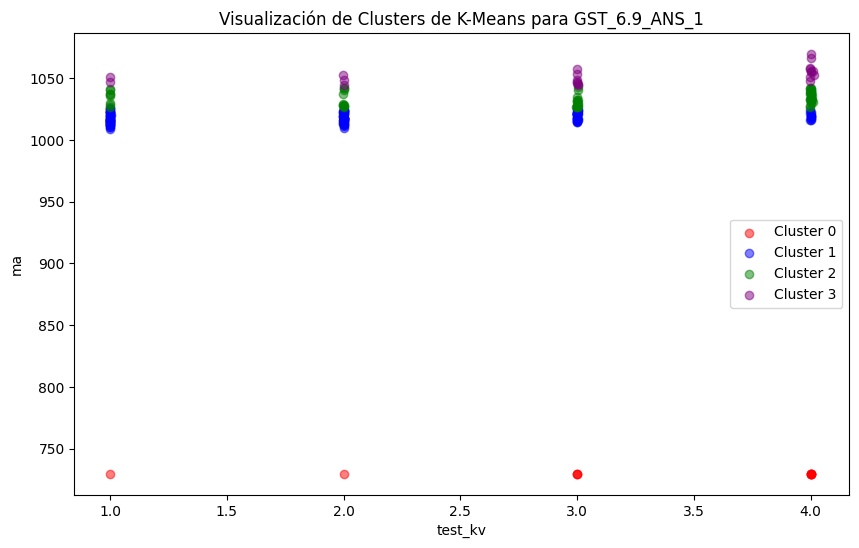

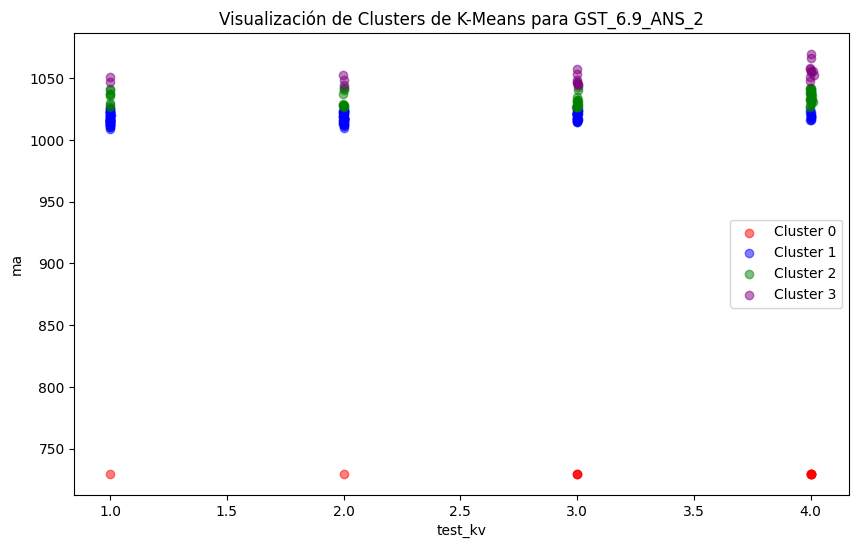

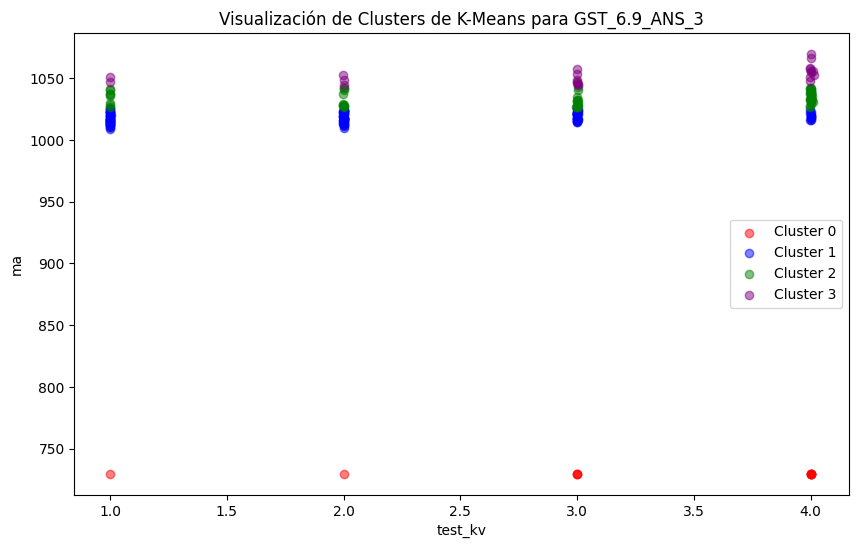

In [50]:
visualizar_kmeans_list(procesar_lista_objetos_test,3)